# 1. PubMed

Search PubMed for papers

https://www.ncbi.nlm.nih.gov/pubmed/

https://www.ncbi.nlm.nih.gov/books/NBK25499/

In [58]:
from collections import Counter
import os
from textwrap import wrap

from Bio import Entrez
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import source.reuse as reuse

In [2]:
ENTREZ_EMAIL = 'lumccul3@gmail.com'

base_query = '("radiation therapy" OR "radiotherapy" OR "head and neck") AND ("robust optimization" OR "queuing systems" OR "operations research" OR "operational research" OR "markov decision process" OR "stochastic program" OR "stochastic processes" OR "combinatorial optimization" OR "discrete optimization" OR "approximation algorithms" OR "heuristics" OR "dynamic program" OR "dynamic programming" OR "linear program" OR "linear programming" OR "integer program" OR "integer programming" OR "mixed-integer program" OR "mixed-integer programming" OR "stochastic optimization" OR "convex optimization" OR "quadratic optimization" OR "quadratic program" OR "quadratic programming" OR "non-smooth optimization" OR "non-convex optimization") AND ("treatment" OR "toxicity")'
# Other terms added to remove false positives. The more terms added without increasing FPs, the better.
# restriction_query = 'AND ("head and neck")'
# # More restriction keyword ideas: clinical, database, waveform (not suitable on their own due to general mimic term)
# full_query = f'{base_query} AND {restriction_query}'

search_strings = [
    base_query
]

In [3]:
# search_results = reuse.search_list(search_strings, entrez_email)
search_results_all = reuse.search_list(search_strings, ENTREZ_EMAIL, all=True)

In [4]:
# Display number of results
for ss in search_strings:
    result = search_results_all[ss]
    print(f'{ss}:\n - Count: {len(result.index)}')

("radiation therapy" OR "radiotherapy" OR "head and neck") AND ("robust optimization" OR "queuing systems" OR "operations research" OR "operational research" OR "markov decision process" OR "stochastic program" OR "stochastic processes" OR "combinatorial optimization" OR "discrete optimization" OR "approximation algorithms" OR "heuristics" OR "dynamic program" OR "dynamic programming" OR "linear program" OR "linear programming" OR "integer program" OR "integer programming" OR "mixed-integer program" OR "mixed-integer programming" OR "stochastic optimization" OR "convex optimization" OR "quadratic optimization" OR "quadratic program" OR "quadratic programming" OR "non-smooth optimization" OR "non-convex optimization") AND ("treatment" OR "toxicity"):
 - Count: 424


In [5]:
# Write the titles to files
write_dir = os.path.join('search_results', 'pubmed')
os.makedirs(write_dir, exist_ok=True)

search_results_all[base_query].to_csv(os.path.join(write_dir, 'without-constraints-all.csv'), index=False)
# search_results_all[full_query].to_csv(os.path.join(write_dir, 'with-constraints-all.csv'), index=False)

# base_query_file = os.path.join(write_dir, 'without-constraints.txt')
# with open(base_query_file, 'w') as f:
#     for line in search_results[base_query].paper_titles:
#         f.write(line+'\n')

# full_query_file = os.path.join(write_dir, 'with-constraints.txt')
# with open(full_query_file, 'w') as f:
#     for line in search_results[full_query].paper_titles:
#         f.write(line+'\n')

In [6]:
# Create a new one for each year
all_years = sorted(set(list(search_results_all[base_query]['Publication Year'])))
for year in all_years:
    year_df_without = search_results_all[base_query][search_results_all[base_query]['Publication Year'] == year]
    # year_df_with = search_results_all[full_query][search_results_all[full_query]['Publication Year'] == year]
    year_df_without.to_csv(os.path.join(write_dir, f'without-constraints-all_{year}.csv'), index=False)
    # year_df_with.to_csv(os.path.join(write_dir, f'with-constraints-all_{year}.csv'), index=False)

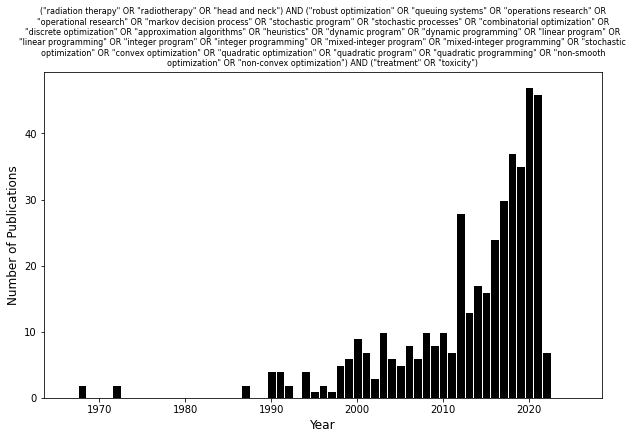

In [7]:
# Create a histogram of number of publications each year
all_years = [int(y) for y in sorted(set(list(search_results_all[base_query]['Publication Year'])))]

year_without = []
year_with = []
interval_years = range(min(all_years), max(all_years)+1)
for year in interval_years:
    year_df_without = search_results_all[base_query][search_results_all[base_query]['Publication Year'] == str(year)]
    # year_df_with = search_results_all[full_query][search_results_all[full_query]['Publication Year'] == str(year)]

    for _ in range(len(year_df_without.index)):
        year_without.append(year)
    # for _ in range(len(year_df_with.index)):
    #     year_with.append(year)

plt.figure(figsize=(10,6))
h = plt.hist(year_without, facecolor='k', edgecolor='w', bins=np.arange(min(interval_years)-1, max(interval_years)+5)-0.5)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Publications', fontsize=12)
plt.ylim([0, 1.05*max(h[0])])
plt.title('\n'.join(wrap(search_strings[0], 140)), fontsize=8)
plt.savefig(os.path.join(write_dir, 'without-constraints_histogram.jpg'))
plt.show()

# plt.figure(figsize=(10,6))
# plt.hist(year_with, facecolor='k', edgecolor='w', bins=np.arange(min(interval_years)-1, max(interval_years)+5)-0.5)
# plt.xlabel('Year', fontsize=12)
# plt.ylabel('Number of Publications', fontsize=12)
# plt.ylim([0, 1.05*max(h[0])])
# plt.title(search_strings[1], fontsize=8)
# plt.savefig(os.path.join(write_dir, 'with-constraints_histogram.jpg'))
# plt.show()

In [60]:
# Assign authors to articles to review
CANCER_AUTHORS = ['Lucas', 'Cem']
OPTIM_AUTHORS = ['Soheil', 'Mohammad', 'Aysenur']
ALL_AUTHORS = [*CANCER_AUTHORS, *OPTIM_AUTHORS]

# Create the dataframe from a subset of the original
assignment_file = search_results_all[base_query][['Title', 'URL']]
total_publications = len(assignment_file.index)

# Cycle through the authors to make it even
optim_index = 0
cancer_index = 0
reviewer1s = []
reviewer2s = []
for p in range(total_publications):
    # Cycle through all authors
    reviewer1s.append(ALL_AUTHORS[p%len(ALL_AUTHORS)])
    # Match authors with their opposite domain
    if reviewer1s[p] in CANCER_AUTHORS:
        reviewer2s.append(OPTIM_AUTHORS[optim_index%len(OPTIM_AUTHORS)])
        optim_index += 1
    elif reviewer1s[p] in OPTIM_AUTHORS:
        reviewer2s.append(CANCER_AUTHORS[cancer_index%len(CANCER_AUTHORS)])
        cancer_index += 1
# Append to the dataframe
assignment_file['Reviewer1'] = reviewer1s
assignment_file['Decision1'] = total_publications*['']
assignment_file['Comments1'] = total_publications*['']
assignment_file['Reviewer2'] = reviewer2s
assignment_file['Decision2'] = total_publications*['']
assignment_file['Comments2'] = total_publications*['']
assignment_file = assignment_file.sort_values(by=['Reviewer1'])

assignment_file.to_csv(os.path.join(write_dir, f'assignment_file.csv'), index=False)

/Users/lmccullum/Documents/Lucas-Mc_citation-tracker/env/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lmccullum/Documents/Lucas-Mc_citation-tracker/env/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lmccullum/Documents/Lucas-Mc_citation-tracker/env/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [59]:
# Total
print('Total:\n')
print('Author   | Reviewer 1 | Reviewer 2')
print('---------|------------|-----------')
for a in ALL_AUTHORS:
    c1 = reviewer1s.count(a)
    c2 = reviewer2s.count(a)
    print(f'{a:8} | {c1:^10} | {c2:^10}')

# Combinations
print('\nCombinations:\n')
print(dict(Counter(tuple(sorted(tup)) for tup in list(zip(reviewer1s, reviewer2s)))))

Total:

Author   | Reviewer 1 | Reviewer 2
---------|------------|-----------
Lucas    |     85     |    127    
Cem      |     85     |    127    
Soheil   |     85     |     57    
Mohammad |     85     |     57    
Aysenur  |     84     |     56    

Combinations:

{('Lucas', 'Soheil'): 72, ('Cem', 'Mohammad'): 72, ('Aysenur', 'Lucas'): 70, ('Cem', 'Soheil'): 70, ('Lucas', 'Mohammad'): 70, ('Aysenur', 'Cem'): 70}


In [ ]:
# TODO: Create a file called without-constraints-inspected.tsv and mark the second column with T/F for true/false positives.

In [ ]:
# Look at the effect of restricting the search by additional criteria.
# The differences show that many false positives, and a few true positives, are removed.
reuse.showdiff(search_results_all[search_strings[0]],
               search_results_all[search_strings[1]])

In [ ]:
# Read in the labelled results for the general unconstrained search query
labelled_results = pd.read_csv(os.path.join(write_dir, 'without-constraints-inspected.tsv'), delimiter='\t', header=None)
false_positives = labelled_results.loc[labelled_results[1]=='F'][0].values
true_positives = labelled_results.loc[labelled_results[1]=='T'][0].values
print('Number of results found using the unconstrained search term:', len(labelled_results))
print('Number of false positives:', len(false_positives))
print('Number of true positives:', len(true_positives))

constrained_titles = search_results[search_strings[1]].paper_titles
print('\nCompare ^ true positives with:')
print('Number of results from the constrained search term:', len(constrained_titles))

missed_papers = set(true_positives) - set(constrained_titles)
print('Number of missed true positives:', len(missed_papers))

In [ ]:
# Take a look at some True positives missed by the constrained search term to figure out what else you can add.
# Write to a file to label comments.
write_dir = os.path.join('search_results', 'pubmed')

missed_papers_file = os.path.join(write_dir, 'missed-papers.tsv')

with open(missed_papers_file, 'w') as f:
    for line in missed_papers:
        f.write(line+'\n')

display(missed_papers)

# 2. Web of Science

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import re
import time
from IPython.display import display


base_mimic_query = '(mimic-ii OR mimic-iii OR mimicii OR mimiciii OR mimic-2 OR mimic-3 OR mimic2 OR mimic3)'
restriction_query = '(physionet OR icu OR “intensive care” OR “critical care”)'
def full_query(base_query, restriction_query):
    return ' AND '.join([base_query, restriction_query])
full_mimic_query = full_query(base_mimic_query, restriction_query)
#base_search_url = 'https://apps.webofknowledge.com/WOS_GeneralSearch_input.do?product=WOS&search_mode=GeneralSearch&SID=2F46AeWkMQBRAZlzDWm&preferencesSaved='
base_search_url = 'https://apps.webofknowledge.com/WOS_GeneralSearch_input.do?product=WOS&search_mode=GeneralSearch&SID=1AnC2UMojuKrtrl7T5R&preferencesSaved='

all_titles = []

In [ ]:
# Get to the search page
driver = webdriver.Firefox()
driver.get(base_search_url)

# Input the query string
time.sleep(2.5)
searchbox = driver.find_element_by_id('value(input1)')
searchbox.send_keys(full_mimic_query)

# Search
time.sleep(1)
searchbutton = driver.find_element_by_css_selector('.standard-button.primary-button.large-search-button')
searchbutton.click()

# Get the total number of pages
npages = int(driver.find_element_by_id('pageCount.top').text)

In [ ]:
# Get the titles!!!
while True:
    # Get the current page number
    pagenum = int(driver.find_element_by_class_name('goToPageNumber-input').get_property('value'))

    # Get the titles. This also captures the journals. So every second value is not a title.
    elements = driver.find_elements_by_class_name('smallV110')

    for e in elements[::2]:
        all_titles.append(e.find_element_by_tag_name('value').text)
        
    if pagenum < npages:
        nextbutton = driver.find_element_by_class_name('paginationNext')
        nextbutton.click()
    else:
        print('Got all paper titles!')
        driver.close()
        break
        
all_titles = set(all_titles)
#all_titles.remove('')
all_titles = [t.lower() for t in list(all_titles)]

In [ ]:
display(all_titles)

In [ ]:
# Write the titles to files
write_dir = os.path.join('search_results/wos')

full_query_file = os.path.join(write_dir, 'with-constraints.txt')

with open(full_query_file, 'w') as f:
    for line in all_titles:
        f.write(line+'\n')

# 3. SCOPUS

Shit search

# 4. IEEE

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import re
import time
from IPython.display import display
import os

base_mimic_query = '(mimic-ii OR mimic-iii OR mimicii OR mimiciii OR mimic-2 OR mimic-3 OR mimic2 OR mimic3)'
restriction_query = '(physionet OR icu OR “intensive care” OR “critical care”)'
def full_query(base_query, restriction_query):
    return ' AND '.join([base_query, restriction_query])
full_mimic_query = full_query(base_mimic_query, restriction_query)
base_search_url = 'http://ieeexplore.ieee.org/search/advsearch.jsp?expression-builder'
all_titles = []

In [ ]:
# Get to the search page
driver = webdriver.Firefox()
driver.get(base_search_url)

# Input the query string
searchbox = driver.find_element_by_id('expression-textarea')
searchbox.send_keys(full_mimic_query)
# Select the 'full text and metadata' box
radiobutton = driver.find_element_by_id('Search_All_Text')
radiobutton.click()

# Search
time.sleep(1)
searchbutton = driver.find_element_by_class_name('stats-Adv_Command_search')
searchbutton.click()

# Get the total number of pages
#npages = int(driver.find_element_by_id('pageCount.top').text)

In [ ]:
# Get the titles!!!
while True:
    # let the page load
    time.sleep(2)
    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(0.5)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
        
    # Get the titles.
    # They are in: <h2 class="result-item-title"><a class="ng-binding ng-scope">title</a></h2>
    elements = driver.find_elements_by_class_name('result-item-title')
    for e in elements:
        # Text may appear with "[::sometext::]"
        all_titles.append(e.find_element_by_tag_name('a').get_attribute('text').replace('[::', '').replace('::]', ''))
        # New line separated journal info and such
        #all_titles.append(e.text.split('\n')[0])
    
    # Click next page if any
    
    e = driver.find_element_by_class_name('next')
    if 'disabled' in e.get_attribute('class'):
        print('Got all paper titles!')
        driver.close()
        break
    else:
        nextbutton = driver.find_element_by_link_text('>')
        nextbutton.click()

all_titles = set(all_titles)
all_titles = [t.lower() for t in list(all_titles)]

In [ ]:
print(len(all_titles))
display(all_titles)

In [ ]:
# Write the titles to files
write_dir = os.path.join('search_results/ieee')

full_query_file = os.path.join(write_dir, 'with-constraints.txt')

with open(full_query_file, 'w') as f:
    for line in all_titles:
        f.write(line+'\n')

# Combining Results - pubmed, wos, ieee

In [ ]:
result_dir = 'search_results'

combined_results = []
for service in ['pubmed', 'wos', 'ieee']:
    # For pubmed, get the curated true positives from the unconstrained search instead
    if service == 'pubmed':
        df = pd.read_csv(os.path.join(result_dir, service, 'without-constraints-inspected.tsv'), delimiter='\t', header=None)
        service_results = list(df.loc[df[1]=='T'][0].values)
    # For other services, get the constrained search results
    else:
        with open(os.path.join(result_dir, service, 'with-constraints.txt')) as f:
            service_results = f.readlines()
    print('Number of results from service '+service+': '+str(len(service_results)))
    combined_results = combined_results + [r.strip() for r in service_results]

print('\nTotal number of non-unique results: ', len(combined_results))
combined_results = sorted(list(set(combined_results)))
print('Total number of unique results: ', len(combined_results))
with open(os.path.join(result_dir, 'combined', 'with-constraints.txt'), 'w') as f:
    for r in combined_results:
        f.write(r+'\n')

In [ ]:
# may 21 2018
Number of results from service pubmed: 155
Number of results from service wos: 152
Number of results from service ieee: 322

Total number of non-unique results:  629
Total number of unique results:  456


# Attempting to parse GS automatically failed. Below is evidence of failure. Can ignore...

# N. Search Google Scholar

Packages found online:
- https://github.com/ckreibich/scholar.py
- https://github.com/venthur/gscholar
- https://github.com/adeel/google-scholar-scraper
- http://code.activestate.com/recipes/523047-search-google-scholar/
- https://github.com/erdiaker/torrequest
- https://github.com/NikolaiT/GoogleScraper


- https://stackoverflow.com/questions/8049520/web-scraping-javascript-page-with-python


Query: `("mimic ii" OR "mimic iii") AND ("database" OR "clinical" OR "waveform" OR ICU)`

https://scholar.google.com/scholar?q=%28mimic-ii+OR+mimic-iii%29&btnG=&hl=en&as_sdt=1%2C22&as_vis=1

https://scholar.google.com/scholar/help.html


https://superuser.com/questions/565722/how-to-config-tor-to-use-a-http-socks-proxy

## Requirements

1. Browse with JS enabled. requests library uses http. Otherwise google will think (correctly) that you are a robot.
2. Change IP every time, or google will block.

In [ ]:
#from torrequest import TorRequest
from bs4 import BeautifulSoup
import urllib2
import getpass
import sys

import stem
import stem.connection

from stem.control import Controller

In [ ]:
# Show IP address
with TorRequest(proxy_port=9050, ctrl_port=9051, password=None) as tr:
    response = tr.get('http://ipecho.net/plain')
    print(response.text)
    tr.reset_identity


In [ ]:
# Show IP address
with TorRequest(proxy_port=9050, ctrl_port=9051, password=None) as tr:
    response = tr.get('http://ipecho.net/plain')
    print(response.text)
    tr.reset_identity

In [ ]:
with TorRequest(proxy_port=9050, ctrl_port=9051, password=None) as tr:

    # Specify HTTP verb and url.
    resp = tr.get('https://scholar.google.com/scholar?q=%28mimic-ii+OR+mimic-iii%29&hl=en&as_sdt=1%2C22&as_vis=1&as_ylo=2017&as_yhi=2017')
    print(resp.text)

    # Change your Tor circuit,
    # and likely your observed IP address.
    tr.reset_identity()



In [ ]:
type(resp.text)

In [ ]:
soup = BeautifulSoup(resp.text,'html.parser')

In [ ]:
for anchor in soup.find_all('a'):
    print(anchor.get('href', '/'))

In [ ]:
from bs4 import BeautifulSoup
import urllib2

webpage = urllib2.urlopen('http://en.wikipedia.org/wiki/Main_Page')
soup = BeautifulSoup(webpage,'html.parser')
for anchor in soup.find_all('a'):
    print(anchor.get('href', '/'))

In [ ]:
with TorRequest() as tr:
  response = tr.get('http://ipecho.net/plain')
  print(response.text)  # not your IP address


In [ ]:
with TorRequest(proxy_port=9050, ctrl_port=9051, password=None) as tr:

  # Specify HTTP verb and url.
  resp = tr.get('https://scholar.google.com/scholar?q=%28mimic-ii+OR+mimic-iii%29&hl=en&as_sdt=1%2C22&as_vis=1&as_ylo=2017&as_yhi=2017')
  print(resp.text)

#   # Send data. Use basic authentication.
#   resp = tr.post('https://api.example.com', 
#     data={'foo': 'bar'}, auth=('user', 'pass'))'
#   print(resp.json)

  # Change your Tor circuit,
  # and likely your observed IP address.
  tr.reset_identity()

  # TorRequest object also exposes the underlying Stem controller 
  # and Requests session objects for more flexibility.

  print(type(tr.ctrl))            # a stem.control.Controller object
  tr.ctrl.signal('CLEARDNSCACHE') # see Stem docs for the full API

  print(type(tr.session))         # a requests.Session object
  c = cookielib.CookieJar()
  tr.session.cookies.update(c)    # see Requests docs for the full API

In [ ]:
scholar_url = 'https://scholar.google.com/scholar?as_vis=1&q=sepsis+mimic-iii&hl=en&as_sdt=1,22'
echo_ip_url = 'https://www.atagar.com/echo.php'
test_js_url = 'http://127.0.0.1:81/test-js.html'

In [ ]:
with TorRequest(proxy_port=9050, ctrl_port=9051, password=None) as tr:

  # Specify HTTP verb and url.
  resp = tr.get('https://scholar.google.com/scholar?q=%28mimic-ii+OR+mimic-iii%29&hl=en&as_sdt=1%2C22&as_vis=1&as_ylo=2017&as_yhi=2017')
  print(resp.text)

#   # Send data. Use basic authentication.
#   resp = tr.post('https://api.example.com', 
#     data={'foo': 'bar'}, auth=('user', 'pass'))'
#   print(resp.json)

  # Change your Tor circuit,
  # and likely your observed IP address.
  tr.reset_identity()

In [ ]:
import io
import pycurl

import stem.process

from stem.util import term

SOCKS_PORT = 9000

def query(url):
  """
  Uses pycurl to fetch a site using the proxy on the SOCKS_PORT.
  """

  output = io.BytesIO()

  query = pycurl.Curl()
  query.setopt(pycurl.URL, url)
  query.setopt(pycurl.PROXY, 'localhost')
  query.setopt(pycurl.PROXYPORT, SOCKS_PORT)
  query.setopt(pycurl.PROXYTYPE, pycurl.PROXYTYPE_SOCKS5_HOSTNAME)
  query.setopt(pycurl.WRITEFUNCTION, output.write)

  try:
    query.perform()
    return output.getvalue()
  except pycurl.error as exc:
    return "Unable to reach %s (%s)" % (url, exc)


# Start an instance of Tor configured to only exit through Russia. This prints
# Tor's bootstrap information as it starts. Note that this likely will not
# work if you have another Tor instance running.

def print_bootstrap_lines(line):
  if "Bootstrapped " in line:
    print(term.format(line, term.Color.BLUE))


print(term.format("Starting Tor:\n", term.Attr.BOLD))

tor_process = stem.process.launch_tor_with_config(
  config = {
    'SocksPort': str(SOCKS_PORT),
    'ExitNodes': '{ru}',
  },
  init_msg_handler = print_bootstrap_lines,
)

print(term.format("\nChecking our endpoint:\n", term.Attr.BOLD))
print(term.format(query("https://www.atagar.com/echo.php"), term.Color.BLUE))

tor_process.kill()  # stops tor

In [ ]:
q = query("https://www.atagar.com/echo.php")

In [ ]:
import dryscrape
s = dryscrape.Session()
s.set_proxy(port=9050)

In [ ]:
import stem
from stem.control import Controller
from stem.process import launch_tor_with_config
import requests
import dryscrape
import time

class TorRequest(object):
  def __init__(self, 
      proxy_port=9050, 
      ctrl_port=9051,
      password=None):

    self.proxy_port = proxy_port
    self.ctrl_port = ctrl_port
    
    self._tor_proc = None
    if not self._tor_process_exists():
      self._tor_proc = self._launch_tor()

    self.ctrl = Controller.from_port(port=self.ctrl_port)
    self.ctrl.authenticate(password=password)

    self.session = requests.Session()
    self.session.proxies.update({
      'http': 'socks5://localhost:%d' % self.proxy_port,
      'https:': 'socks5://localhost:%d' % self.proxy_port,
    })

  def _tor_process_exists(self):
    try:
      ctrl = Controller.from_port(port=self.ctrl_port)
      ctrl.close()
      return True
    except:
      return False

  def _launch_tor(self):
    return launch_tor_with_config(
      config={
        'SocksPort': str(self.proxy_port),
        'ControlPort': str(self.ctrl_port)
      },
      take_ownership=True)

  def close(self):
    try: 
      self.session.close()
    except: pass

    try: 
      self.ctrl.close()
    except: pass

    if self._tor_proc:
      self._tor_proc.terminate()

  def reset_identity_async(self):
    self.ctrl.signal(stem.Signal.NEWNYM)

  def reset_identity(self):
    self.reset_identity_async()
    time.sleep(self.ctrl.get_newnym_wait())

  def get(self, *args, **kwargs):
    return self.session.get(*args, **kwargs)

  def post(self, *args, **kwargs):
    return self.session.post(*args, **kwargs)

  def put(self, *args, **kwargs):
    return self.session.put(*args, **kwargs)

  def patch(self, *args, **kwargs):
    return self.session.patch(*args, **kwargs)
    
  def delete(self, *args, **kwargs):
    return self.session.delete(*args, **kwargs)

  def __enter__(self):
    return self

  def __exit__(self, *args):
    self.close()

In [ ]:
# Show IP address
with TorRequest(proxy_port=9050, ctrl_port=9051, password='16:872860B76453A77D60CA2BB8C1A7042072093276A3D701AD684053EC4C') as tr:
    response = tr.get('http://ipecho.net/plain')
    print(response.text)
    tr.reset_identity

In [ ]:
import dryscrape
import sys
from bs4 import BeautifulSoup
import time

scholar_url = 'https://scholar.google.com/scholar?as_vis=1&q=sepsis+mimic-iii&hl=en&as_sdt=1,22'
echo_ip_url = 'http://ipecho.net/plain'
test_js_url = 'http://127.0.0.1:81/test-js.html'

if 'linux' in sys.platform:
    # start xvfb in case no X is running. Make sure xvfb 
    # is installed, otherwise this won't work!
    dryscrape.start_xvfb()

In [ ]:
s = dryscrape.Session()
s.visit(test_js_url)
s.body()

#s.visit('https://scholar.google.com/scholar?as_vis=1&q=sepsis+mimic-iii&hl=en&as_sdt=1,22')
# waiting for the first data row in a table to be present
# s.wait_for(lambda: s.at_css("tr.data-row0"))

# soup = BeautifulSoup(s.body(), 'lxml')

In [ ]:
s = dryscrape.Session()

s.set_proxy(host = "localhost", port = 8118)
#time.sleep(20)
s.visit(echo_ip_url)
#s.body()

In [ ]:
s.body()